In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

In [21]:

# Load the dataset
df = pd.read_csv("10 pipe dataset.csv")

In [22]:
# Display basic information
print(df.head())
print(df.shape)
print(df.info())

       Time Day_of_week Age_band_of_driver Sex_of_driver   Educational_level  \
0  17:02:00      Monday              18-30          Male   Above high school   
1  17:02:00      Monday              31-50          Male  Junior high school   
2  17:02:00      Monday              18-30          Male  Junior high school   
3   1:06:00      Sunday              18-30          Male  Junior high school   
4   1:06:00      Sunday              18-30          Male  Junior high school   

  Vehicle_driver_relation Driving_experience      Type_of_vehicle  \
0                Employee              1-2yr           Automobile   
1                Employee         Above 10yr  Public (> 45 seats)   
2                Employee              1-2yr      Lorry (41?100Q)   
3                Employee             5-10yr  Public (> 45 seats)   
4                Employee              2-5yr                  NaN   

  Owner_of_vehicle Service_year_of_vehicle  ... Vehicle_movement  \
0            Owner              Abov

Accident_severity
Slight Injury     10415
Serious Injury     1743
Fatal injury        158
Name: count, dtype: int64


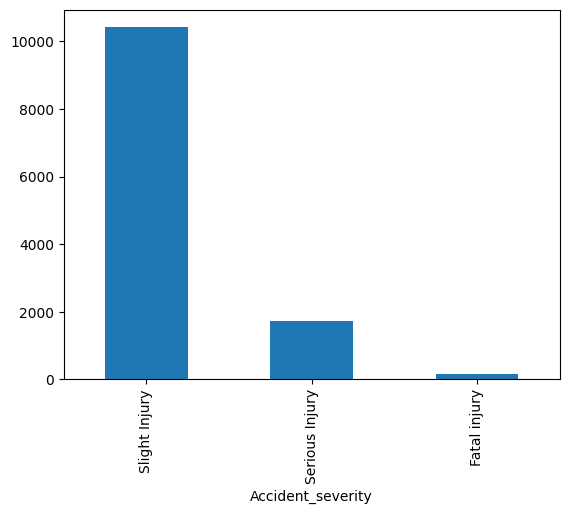

In [23]:

# Visualize target variable distribution
print(df['Accident_severity'].value_counts())
df['Accident_severity'].value_counts().plot(kind='bar')
plt.show()

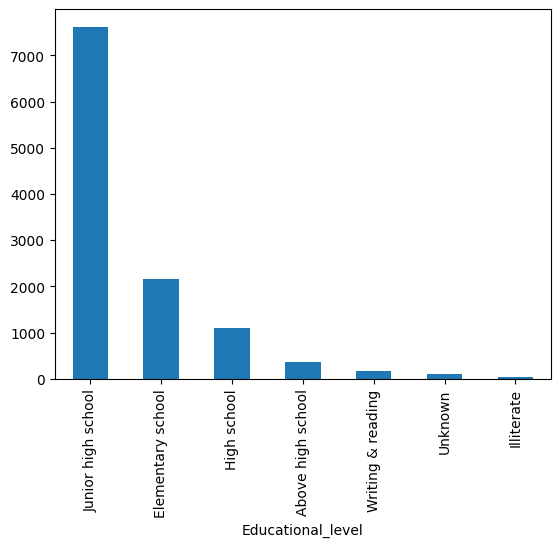

In [24]:

# Exploratory Data Analysis
# Plot education levels
df['Educational_level'].value_counts().plot(kind='bar')
plt.show()


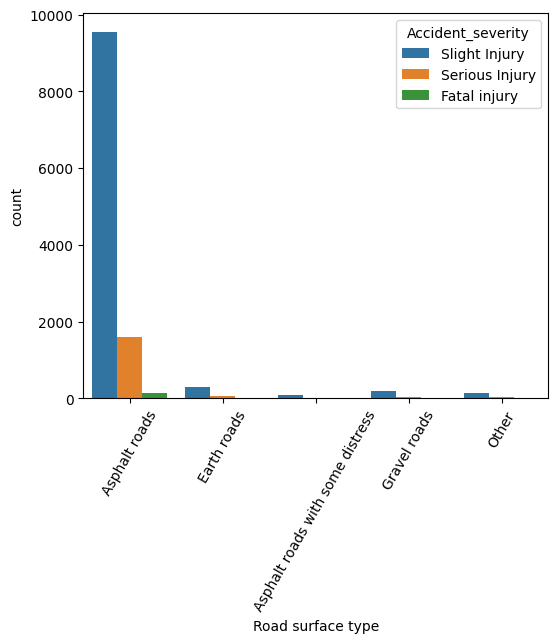

In [25]:
# Plot road surface type vs accident severity
plt.figure(figsize=(6,5))
sns.countplot(x='Road_surface_type', hue='Accident_severity', data=df)
plt.xlabel('Road surface type')
plt.xticks(rotation=60)
plt.show()

In [26]:
# Data Preparation: Convert Time to Hour_of_Day
df['Time'] = pd.to_datetime(df['Time'])
new_df = df.copy()
new_df['Hour_of_Day'] = df['Time'].dt.hour
new_df.drop('Time', axis=1, inplace=True)
print(new_df.head())

  Day_of_week Age_band_of_driver Sex_of_driver   Educational_level  \
0      Monday              18-30          Male   Above high school   
1      Monday              31-50          Male  Junior high school   
2      Monday              18-30          Male  Junior high school   
3      Sunday              18-30          Male  Junior high school   
4      Sunday              18-30          Male  Junior high school   

  Vehicle_driver_relation Driving_experience      Type_of_vehicle  \
0                Employee              1-2yr           Automobile   
1                Employee         Above 10yr  Public (> 45 seats)   
2                Employee              1-2yr      Lorry (41?100Q)   
3                Employee             5-10yr  Public (> 45 seats)   
4                Employee              2-5yr                  NaN   

  Owner_of_vehicle Service_year_of_vehicle Defect_of_vehicle  ...  \
0            Owner              Above 10yr         No defect  ...   
1            Owner        

C:\Windows\Temp\ipykernel_3908\3482959599.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


In [27]:
# Encode Target Column
lb = LabelEncoder()
new_df['Accident_severity'] = lb.fit_transform(new_df['Accident_severity'])
print(new_df.head())


  Day_of_week Age_band_of_driver Sex_of_driver   Educational_level  \
0      Monday              18-30          Male   Above high school   
1      Monday              31-50          Male  Junior high school   
2      Monday              18-30          Male  Junior high school   
3      Sunday              18-30          Male  Junior high school   
4      Sunday              18-30          Male  Junior high school   

  Vehicle_driver_relation Driving_experience      Type_of_vehicle  \
0                Employee              1-2yr           Automobile   
1                Employee         Above 10yr  Public (> 45 seats)   
2                Employee              1-2yr      Lorry (41?100Q)   
3                Employee             5-10yr  Public (> 45 seats)   
4                Employee              2-5yr                  NaN   

  Owner_of_vehicle Service_year_of_vehicle Defect_of_vehicle  ...  \
0            Owner              Above 10yr         No defect  ...   
1            Owner        

In [28]:

# Balance Dataset
print(new_df['Accident_severity'].value_counts())
X = new_df.drop(columns=['Accident_severity'])
y = new_df['Accident_severity']
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)
print(y_resampled.value_counts(), X_resampled.shape)

Accident_severity
2    10415
1     1743
0      158
Name: count, dtype: int64
Accident_severity
2    10415
1    10415
0    10415
Name: count, dtype: int64 (31245, 31)


In [29]:


# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [30]:

# Fill Missing Values
strategies = {
    3: 'most_frequent',   # Educational_level
    4: 'most_frequent',   # Vehicle_driver_relation
    5: 'most_frequent',   # Driving_experience
    6: 'most_frequent',   # Type_of_vehicle
    8: 'constant',        # Service_year_of_vehicle
    9: 'constant',        # Defect_of_vehicle
    10: 'most_frequent',  # Area_accident_occured
    11: 'most_frequent',  # Lanes_or_Medians
    12: 'most_frequent',  # Road_allignment
    13: 'most_frequent',  # Types_of_Junction
    14: 'most_frequent',  # Road_surface_type
    18: 'most_frequent',  # Type_of_collision
    21: 'most_frequent',  # Vehicle_movement
    26: 'most_frequent',  # Work_of_casualty
    27: 'most_frequent'   # Fitness_of_casualty
}

In [31]:
tf1 = ColumnTransformer([
    ('impute_educational_level', SimpleImputer(strategy=strategies[3]), [3]),
    ('impute_vehicle_driver_relation', SimpleImputer(strategy=strategies[4]), [4]),
    ('impute_driving_experience', SimpleImputer(strategy=strategies[5]), [5]),
    ('impute_type_of_vehicle', SimpleImputer(strategy=strategies[6]), [6]),
    ('impute_service_year_of_vehicle', SimpleImputer(strategy=strategies[8], fill_value='Unknown'), [8]),
    ('impute_defect_of_vehicle', SimpleImputer(strategy=strategies[9], fill_value='Unknown'), [9]),
    ('impute_area_accident_occured', SimpleImputer(strategy=strategies[10]), [10]),
    ('impute_lanes_or_medians', SimpleImputer(strategy=strategies[11]), [11]),
    ('impute_road_allignment', SimpleImputer(strategy=strategies[12]), [12]),
    ('impute_types_of_junction', SimpleImputer(strategy=strategies[13]), [13]),
    ('impute_road_surface_type', SimpleImputer(strategy=strategies[14]), [14]),
    ('impute_type_of_collision', SimpleImputer(strategy=strategies[18]), [18]),
    ('impute_vehicle_movement', SimpleImputer(strategy=strategies[21]), [21]),
    ('impute_work_of_casualty', SimpleImputer(strategy=strategies[26]), [26]),
    ('impute_fitness_of_casualty', SimpleImputer(strategy=strategies[27]), [27])
], remainder='passthrough')


In [32]:
# Encode Categorical Columns
object_columns_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
tf2 = ColumnTransformer([
    (f'ohe_{col}', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), [col])
    for col in object_columns_indices
], remainder='passthrough')


In [33]:

# Scaling Numerical Columns
# Numerical columns after imputation and encoding: Number_of_vehicles_involved (19), Number_of_casualties (20), Hour_of_Day (30)
# After one-hot encoding, these indices shift due to new columns created. We scale all columns post-encoding.
tf3 = MinMaxScaler()

In [34]:
# Feature Selection using Chi2
tf4 = SelectKBest(chi2, k=50)

In [35]:
# Model: Random Forest Classifier
tf5 = RandomForestClassifier()


In [36]:
# Create Pipeline
pipe = Pipeline([
    ('trf1', tf1),  # Imputation
    ('trf2', tf2),  # One-hot encoding
    ('trf3', tf3),  # Scaling
    ('trf4', tf4),  # Feature selection
    ('trf5', tf5)   # Model
])


In [37]:

# Train the pipeline
pipe.fit(X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_educational_level',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [3]),
                                                 ('impute_vehicle_driver_relation',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [4]),
                                                 ('impute_driving_experience',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [5]),
                                                 ('impute_type_of_vehicle',
                                                  SimpleImputer(stra...
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [27]),
                                                 ('ohe_28',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [28]),
                                                 ('ohe_29',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [29]), ...])),
                ('trf3', MinMaxScaler()),
                ('trf4',
                 SelectKBest(k=50,
                             score_func=<function chi2 at 0x0000018AD2133E20>)),
                ('trf5', RandomForestClassifier())])

In [38]:
# Predict
y_pred = pipe.predict(X_test)


In [39]:


# Evaluate
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy Score: 0.9259081453032485

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      2085
           1       0.86      0.95      0.90      2100
           2       0.95      0.83      0.89      2064

    accuracy                           0.93      6249
   macro avg       0.93      0.93      0.93      6249
weighted avg       0.93      0.93      0.93      6249


Confusion Matrix:
 [[2085    0    0]
 [  22 1995   83]
 [  25  333 1706]]


In [40]:
# Explore the pipeline
print("\nPipeline Steps:", pipe.named_steps)



Pipeline Steps: {'trf1': ColumnTransformer(remainder='passthrough',
                  transformers=[('impute_educational_level',
                                 SimpleImputer(strategy='most_frequent'), [3]),
                                ('impute_vehicle_driver_relation',
                                 SimpleImputer(strategy='most_frequent'), [4]),
                                ('impute_driving_experience',
                                 SimpleImputer(strategy='most_frequent'), [5]),
                                ('impute_type_of_vehicle',
                                 SimpleImputer(strategy='most_frequent'), [6...
                                ('impute_road_surface_type',
                                 SimpleImputer(strategy='most_frequent'),
                                 [14]),
                                ('impute_type_of_collision',
                                 SimpleImputer(strategy='most_frequent'),
                                 [18]),
            

In [41]:

# Save the pipeline
pickle.dump(pipe, open("10 pipe.pkl", 'wb'))

In [42]:
# Prediction System

In [43]:

# Load the pipeline
pipe = pickle.load(open("10 pipe.pkl", 'rb'))

In [44]:
# Test prediction with a sample input
test_input = np.array(['Thursday', '31-50', 'Male', 'Junior high school', 'Owner', 'Unknown', 'Long lorry', 'Owner', 
                       'Unknown', 'Unknown', 'Other', 'Two-way (divided with solid lines road marking)',
                       'Tangent road with flat terrain', 'Unknown', 'Unknown', 'Dry', 'Daylight', 'Normal', 
                       'Collision with animals', 2, 1, 'Going straight', 'Driver or rider', 'Male', '18-30', 3, 'Driver',
                       'Normal', 'Not a Pedestrian', 'Changing lane to the left', 12], dtype=object).reshape(1, -1)
print("Prediction:", pipe.predict(test_input))
print("Actual:", y_test.iloc[10])

Prediction: [1]
Actual: 1


d:\MLP\Road-accidents-pipeline\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
d:\MLP\Road-accidents-pipeline\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
d:\MLP\Road-accidents-pipeline\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
d:\MLP\Road-accidents-pipeline\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
d:\MLP\Road-accidents-pipeline\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature nam

In [45]:

# Prediction function
def pred(Day_of_week, Age_band_of_driver, Sex_of_driver, Educational_level, Vehicle_driver_relation,
         Driving_experience, Type_of_vehicle, Owner_of_vehicle, Service_year_of_vehicle,
         Defect_of_vehicle, Area_accident_occured, Lanes_or_Medians, Road_allignment,
         Types_of_Junction, Road_surface_type, Road_surface_conditions, Light_conditions,
         Weather_conditions, Type_of_collision, Number_of_vehicles_involved,
         Number_of_casualties, Vehicle_movement, Casualty_class, Sex_of_casualty,
         Age_band_of_casualty, Casualty_severity, Work_of_casualty, Fitness_of_casualty,
         Pedestrian_movement, Cause_of_accident, Hour_of_Day):
    features = np.array([[Day_of_week, Age_band_of_driver, Sex_of_driver, Educational_level, Vehicle_driver_relation,
                          Driving_experience, Type_of_vehicle, Owner_of_vehicle, Service_year_of_vehicle,
                          Defect_of_vehicle, Area_accident_occured, Lanes_or_Medians, Road_allignment,
                          Types_of_Junction, Road_surface_type, Road_surface_conditions, Light_conditions,
                          Weather_conditions, Type_of_collision, Number_of_vehicles_involved,
                          Number_of_casualties, Vehicle_movement, Casualty_class, Sex_of_casualty,
                          Age_band_of_casualty, Casualty_severity, Work_of_casualty, Fitness_of_casualty,
                          Pedestrian_movement, Cause_of_accident, Hour_of_Day]], dtype=object)
    results = pipe.predict(features)
    return results


In [46]:

# Test case 1
predicted_class = pred(
    Day_of_week="Thursday", Age_band_of_driver='31-50', Sex_of_driver='Male', Educational_level='Junior high school',
    Vehicle_driver_relation='Owner', Driving_experience=None, Type_of_vehicle='Long lorry', Owner_of_vehicle='Owner',
    Service_year_of_vehicle='Unknown', Defect_of_vehicle=None, Area_accident_occured='Other',
    Lanes_or_Medians='Two-way (divided with solid lines road marking)', Road_allignment='Tangent road with flat terrain',
    Types_of_Junction=None, Road_surface_type=None, Road_surface_conditions='Dry', Light_conditions='Daylight',
    Weather_conditions='Normal', Type_of_collision='Collision with animals', Number_of_vehicles_involved=2,
    Number_of_casualties=1, Vehicle_movement='Going straight', Casualty_class='Driver or rider', Sex_of_casualty='Male',
    Age_band_of_casualty='18-30', Casualty_severity=3, Work_of_casualty='Driver', Fitness_of_casualty='Normal',
    Pedestrian_movement='Not a Pedestrian', Cause_of_accident='Changing lane to the left', Hour_of_Day=12
)
if predicted_class[0] == 2:
    print("Slight Injury")
elif predicted_class[0] == 1:
    print("Serious Injury")
else:
    print("Fatal Injury")

Serious Injury


d:\MLP\Road-accidents-pipeline\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
d:\MLP\Road-accidents-pipeline\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
d:\MLP\Road-accidents-pipeline\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
d:\MLP\Road-accidents-pipeline\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
d:\MLP\Road-accidents-pipeline\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature nam

In [47]:



# Test case 2
predicted_class = pred(
    Day_of_week="Friday", Age_band_of_driver='31-50', Sex_of_driver='Male', Educational_level='Elementary school',
    Vehicle_driver_relation='Employee', Driving_experience='1-2yr', Type_of_vehicle='Lorry (41?100Q)', Owner_of_vehicle='Owner',
    Service_year_of_vehicle=None, Defect_of_vehicle='No defect', Area_accident_occured='Office areas',
    Lanes_or_Medians='Two-way (divided with broken lines road marking)', Road_allignment='Tangent road with flat terrain',
    Types_of_Junction='Y Shape', Road_surface_type='Asphalt roads', Road_surface_conditions='Dry', Light_conditions='Daylight',
    Weather_conditions='Normal', Type_of_collision='Vehicle with vehicle collision', Number_of_vehicles_involved=2,
    Number_of_casualties=2, Vehicle_movement='Going straight', Casualty_class='na', Sex_of_casualty='na',
    Age_band_of_casualty='na', Casualty_severity='na', Work_of_casualty='Driver', Fitness_of_casualty='Normal',
    Pedestrian_movement='Not a Pedestrian', Cause_of_accident='Changing lane to the left', Hour_of_Day=1
)
if predicted_class[0] == 2:
    print("Slight Injury")
elif predicted_class[0] == 1:
    print("Serious Injury")
else:
    print("Fatal Injury")

Slight Injury


d:\MLP\Road-accidents-pipeline\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
d:\MLP\Road-accidents-pipeline\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
d:\MLP\Road-accidents-pipeline\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
d:\MLP\Road-accidents-pipeline\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
d:\MLP\Road-accidents-pipeline\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature nam